## Modelling of gas flow into Bacton via Interconnector pipeline

First we import required libraries.

In [50]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

Get flow data from interconnector website and merge into a single dataframe.

In [51]:
df2016 = pd.read_csv("http://www.interconnector.com/Data/ISIS/flowdata/interconnector_flow_data_2016.csv", skiprows=1)
df2017 = pd.read_csv("http://www.interconnector.com/Data/ISIS/flowdata/interconnector_flow_data_2017.csv", skiprows=1)
dfflow = df2016.append(df2017)
dfflow = dfflow.drop_duplicates()

Convert dates to datetime objects:

In [52]:
dfflow = dfflow.rename(columns={'Gas Day ':'Date'})
date_cols = ['Date']
for i in date_cols:
    dfflow[i] = pd.to_datetime(dfflow[i], format='%d-%b-%Y')

Get price data from excel sheet provided and examine data.

In [53]:
dfprices = pd.read_excel("data.xlsx")
dfprices.head(10)

,Date,NBP Price,TTF Price,GBPUSD,EURUSD
0,2016-10-04,33.75,12.50,1.2728,1.1204
1,2016-10-05,35.40,13.82,1.2749,1.1205
2,2016-10-06,37.35,14.95,1.2616,1.1151
3,2016-10-07,40.45,15.38,1.2434,1.1201
4,2016-10-08,42.30,15.45,NaN,NaN
5,2016-10-09,42.30,15.45,NaN,NaN
6,2016-10-10,42.30,15.45,1.2362,1.1139
7,2016-10-11,41.00,15.60,1.2123,1.1054
8,2016-10-12,41.50,15.55,1.2204,1.1007
9,2016-10-13,41.50,15.35,1.2254,1.1056


We realize that exchange rates are missing on weekends. It is reasonable to do a linear interpolation:

In [54]:
dfprices['GBPUSD'] = dfprices['GBPUSD'].interpolate()
dfprices['EURUSD'] = dfprices['EURUSD'].interpolate()

Now merge flow data with price data, and manipulate to get price differential in USD.

In [55]:
df = dfflow.merge(dfprices,on='Date',how='inner') 

# Convert all prices to USD
df['UK Price'] = df['NBP Price']*df['GBPUSD'] 
df['EU Price'] = df['TTF Price']*df['EURUSD'] 

# Get price differential
df['Price Diff'] = df['UK Price']-df['EU Price']

There are some observations where daily flow is 0 (Outage). We drop these observations so that the model is more representative of usual operations.

In [56]:
df = df.replace({0:None})
df = df.dropna()

Now we can perform a simple (single variable) linear regression. We first separate a train set and test set.

In [65]:
df = df.sample(frac=1)
X = df['Price Diff'].values.reshape(-1,1)
X_train = X[:-50]
X_test = X[-50:]
Y = df['Daily Flow (kWh)']
Y_train = Y[:-50]
Y_test = Y[-50:]


regr = linear_model.LinearRegression()
regr.fit(X_train,Y_train)

Y_pred = regr.predict(X_test)

# Print regression results and metrics
print('Coefficients: \n', regr.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, Y_pred))
print('R^2: %.5f' % r2_score(Y_test, Y_pred))

Coefficients: 
 [-44533892.59849727]
Mean squared error: 41462097199477296.00
R^2: 0.72985


Visualizing the results:

Text(0,0.5,'Daily Flow (kWh)')

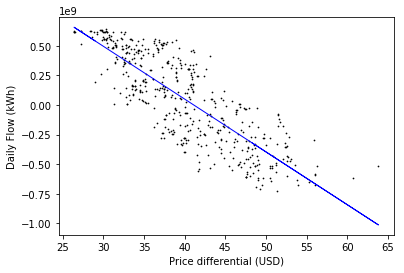

In [66]:
Y_pred_all = regr.predict(X) #Look at the whole data set
plt.scatter(X,Y,color='black',s=0.5)
plt.plot(X,Y_pred_all,color='blue', linewidth=1)
plt.xlabel('Price differential (USD)')
plt.ylabel('Daily Flow (kWh)')

Text(0,0.5,'Daily Flow (kWh)')

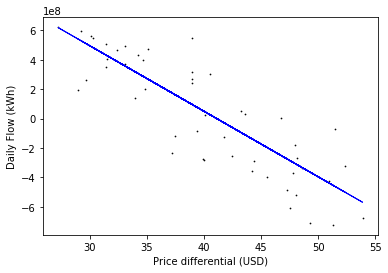

In [68]:
Y_pred_test = regr.predict(X_test) #Look only at test set
plt.scatter(X_test,Y_test,color='black',s=0.5)
plt.plot(X_test,Y_pred_test,color='blue', linewidth=1)
plt.xlabel('Price differential (USD)')
plt.ylabel('Daily Flow (kWh)')

### Part 2: Adding to the model

Visualizing the gas flow trend over time, we observe some seasonality in the data:

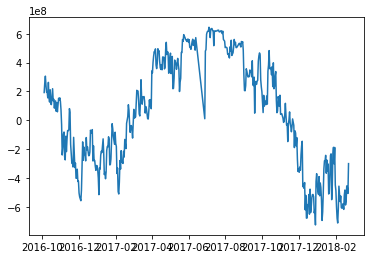

In [59]:
plt.plot(df['Date'],df['Daily Flow (kWh)'])

High inflows correspond to summer months, low inflows to winter months. We can reasonably use temperature as a regressor to predict flow rate. We obtain temperature.csv from the National Oceanic and Atmospheric Administration.

In [60]:
dftemp = pd.read_csv('temperature.csv')

dftemp = dftemp.rename(columns={'DATE':'Date'})
dftemp = dftemp[['Date','TAVG']]
date_cols = ['Date']
for i in date_cols:
    dftemp[i] = pd.to_datetime(dftemp[i], format='%Y-%m-%d')
    
df = dftemp.merge(df,on='Date',how='inner') 

The system average price (SAP) within the UK might also help (obtained from National Grid).

In [61]:
dfSAP = pd.read_csv('SAP.csv')
dfSAP = dfSAP.rename(columns={'Applicable For':'Date', 'Value':'SAP'})
dfSAP = dfSAP[['Date','SAP']]
dfSAP = dfSAP.drop_duplicates()


date_cols = ['Date']
for i in date_cols:
    dfSAP[i] = pd.to_datetime(dfSAP[i], format='%d/%m/%Y')
    
df = dfSAP.merge(df,on='Date',how='inner') 

To verify that they may help explain gas flow, we look at the correlations:

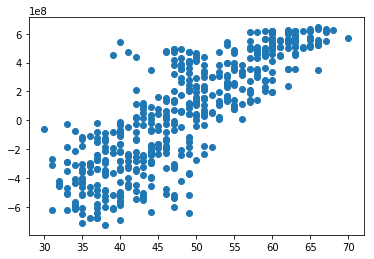

In [62]:
plt.scatter(df['TAVG'],df['Daily Flow (kWh)'])

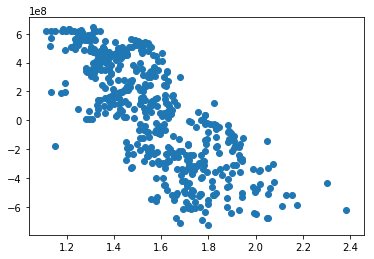

In [63]:
plt.scatter(df['SAP'],df['Daily Flow (kWh)'])

Fit a linear regression model using these additional variables:

In [122]:
df = df.sample(frac=1)
X = df[['Price Diff','TAVG','SAP']]
X_train = X[:-50]
X_test = X[-50:]
Y = df['Daily Flow (kWh)']
Y_train = Y[:-50]
Y_test = Y[-50:]


regr = linear_model.LinearRegression()
regr.fit(X_train,Y_train)

Y_pred = regr.predict(X_test)

# Print regression results and metrics
print('Coefficients: \n', regr.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, Y_pred))
print('R^2: %.5f' % r2_score(Y_test, Y_pred))

Coefficients: 
 [-3.60465843e+07  2.12310376e+07  3.57326996e+08]
Mean squared error: 21008393056827488.00
R^2: 0.80188


This is already an improvement over the first model (R^2 = 0.802 > 0.720). Plotting SAP against Price Diff, we realise that they are highly correlated:

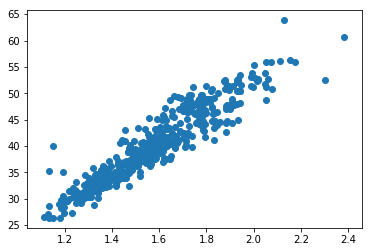

In [80]:
plt.scatter(df['SAP'],df['Price Diff'])

The model might generalize better if we drop one of the variables.

In [118]:
df = df.sample(frac=1)
X = df[['Price Diff','TAVG']]
X_train = X[:-50]
X_test = X[-50:]
Y = df['Daily Flow (kWh)']
Y_train = Y[:-50]
Y_test = Y[-50:]


regr = linear_model.LinearRegression()
regr.fit(X_train,Y_train)

Y_pred = regr.predict(X_test)

# Print regression results and metrics
print('Coefficients: \n', regr.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, Y_pred))
print('R^2: %.5f' % r2_score(Y_test, Y_pred))

Coefficients: 
 [-27213066.63966488  19244539.25125986]
Mean squared error: 27617239640034780.00
R^2: 0.83614


Indeed it appears to, and the coefficients for the regressors are smaller as well.